# Introdução 
Este projeto tem como objetivo desenvolver um agente inteligente para resolver de planeamento de tarefas com restrições.

# Formulação do Problema 
O problema de planeamento de tarefas é um desafio típico de otimização. Existem dois tipos principais de restrições:

-**Restrições Fortes**: São obrigatórias e devem ser sempre respeitadas. 

    - Exemplo: Precedência de tarefas. 

-**Restrições Leves**: São preferências que podem ser violadas, mas com algum custo.

    -Exemplo: Minimizar a duranção total do projeto.

Neste projeto, vamos trabalhar com um dataset que contém informações sobre tarefas, modos de execução e recursos.


In [1]:
!pip install pandas


In [2]:
!pip install matplotlib seaborn

In [3]:
# Bloco 1: Carregamento e Estruturação dos Dados
# Este bloco tem como objetivo estruturar os dados do ficheiro fornecido para análise posterior.
# É crucial para a implementação de conceitos de CSP (Problemas de Satisfação de Restrições) e IA.

# 1. Importação das bibliotecas necessárias
import pandas as pd

# Função para dividir secções do ficheiro com base em marcadores específicos
def parse_section(lines, start_marker, end_marker=None):
    """
    Função para extrair linhas de uma secção do ficheiro delimitada por marcadores de início e fim.
    
    Args:
        lines (list): Linhas do ficheiro.
        start_marker (str): Marcador que indica o início da secção.
        end_marker (str, opcional): Marcador que indica o fim da secção. 
                                    Se None, a secção vai até ao final do ficheiro.
    
    Returns:
        list: Linhas extraídas da secção.
    """
    start_index = next(i for i, line in enumerate(lines) if start_marker in line) + 1
    if end_marker:
        end_index = next((i for i, line in enumerate(lines[start_index:], start=start_index) if end_marker in line), len(lines))
        return lines[start_index:end_index]
    return lines[start_index:]

# Carregar o ficheiro de dados
# O ficheiro contém a definição do problema, incluindo tarefas, recursos e relações de precedência.
dataset_path = 'C:/Users/Asus/OneDrive/Documents/3AnoLesi/IA/Projeto/p01_dataset_10/p01_dataset_10.txt'
with open(dataset_path, 'r') as file:
    lines = file.readlines()

# Extrair secções do ficheiro
# Cada secção corresponde a um componente fundamental do problema de CSP
projects_summary = parse_section(lines, "#Projects summary", "************************************************************************")
precedence_relations = parse_section(lines, "#Precedence relations", "************************************************************************")
duration_resources = parse_section(lines, "#Duration and resources", "************************************************************************")
resource_availability = parse_section(lines, "#Resource availability", None)

# 2. Criar DataFrames para organizar os dados
# 2.1 Sumário de Projetos
# Contém informações básicas como número de tarefas e datas importantes
projects_df = pd.DataFrame(
    [line.split() for line in projects_summary[1:]],
    columns=['pronr', '#jobs', 'rel.date', 'duedate', 'tardcost', 'MPM-Time']
)
projects_df = projects_df.apply(pd.to_numeric, errors='coerce')  # Converter colunas para valores numéricos

# 2.2 Relações de Precedência
# Define quais tarefas dependem de outras para começar
precedence_data = []
for line in precedence_relations[1:]:
    parts = line.split()
    jobnr, modes, successors = map(int, parts[:3])  # As 3 primeiras colunas
    successors_list = list(map(int, parts[3:]))  # Lista de sucessores
    # Adicionar sucessores como colunas separadas
    while len(successors_list) < 3:  # Garantir 3 colunas de sucessores
        successors_list.append(None)
    precedence_data.append([jobnr, modes, successors] + successors_list)

precedence_df = pd.DataFrame(precedence_data, columns=['#jobnr', '#modes', '#successors', 'successor1', 'successor2', 'successor3'])

# 2.3 Duração e Recursos
# Contém a duração de cada tarefa e os recursos que esta consome
duration_df = pd.DataFrame(
    [line.split() for line in duration_resources[1:]],
    columns=['#jobnr', 'mode', 'duration', 'R1', 'R2']
)
duration_df = duration_df.apply(pd.to_numeric, errors='coerce')  # Converter colunas para valores numéricos

# 2.4 Disponibilidade de Recursos
# Define a quantidade de cada recurso disponível
resources_data = []
for line in resource_availability[1:]:
    if line.strip() and not line.startswith("*"):  # Ignorar linhas vazias e linhas com "*"
        parts = line.split()
        if len(parts) == 2:  # Garantir que existam exatamente duas colunas (recurso e quantidade)
            resources_data.append(parts)

resources_df = pd.DataFrame(resources_data, columns=['#resource', 'qty'])
resources_df['qty'] = pd.to_numeric(resources_df['qty'], errors='coerce')

# 3. Exibir os DataFrames processados
# Estes dados estruturados são a base para aplicar as restrições do problema
print("Sumário de Projetos:")
print(projects_df)

print("\nRelações de Precedência:")
print(precedence_df)

print("\nDuração e Recursos:")
print(duration_df)

print("\nDisponibilidade de Recursos (corrigida):")
print(resources_df)

# Comentário final:
# Este bloco prepara os dados para as fases seguintes, como análise e aplicação de restrições,
# permitindo a verificação de conflitos de precedência e restrições de recursos no contexto de CSP.


Sumário de Projetos:
   pronr  #jobs  rel.date  duedate  tardcost  MPM-Time
0      1     10         0       22         3        22

Relações de Precedência:
    #jobnr  #modes  #successors  successor1  successor2  successor3
0        1       1            3         2.0         3.0         4.0
1        2       3            2         5.0         6.0         NaN
2        3       3            2        10.0        11.0         NaN
3        4       3            1         9.0         NaN         NaN
4        5       3            2         7.0         8.0         NaN
5        6       3            2        10.0        11.0         NaN
6        7       3            2         9.0        10.0         NaN
7        8       3            1         9.0         NaN         NaN
8        9       3            1        12.0         NaN         NaN
9       10       3            1        12.0         NaN         NaN
10      11       3            1        12.0         NaN         NaN
11      12       1         


--- Verificação de Valores Ausentes ---
Sumário de Projetos:
pronr       0
#jobs       0
rel.date    0
duedate     0
tardcost    0
MPM-Time    0
dtype: int64

Relações de Precedência:
#jobnr          0
#modes          0
#successors     0
successor1      1
successor2      6
successor3     11
dtype: int64

Duração e Recursos:
#jobnr      0
mode        0
duration    0
R1          0
R2          0
dtype: int64

Disponibilidade de Recursos:
#resource    0
qty          0
dtype: int64

--- Análise Estatística Básica ---

Sumário de Projetos:
       pronr  #jobs  rel.date  duedate  tardcost  MPM-Time
count    1.0    1.0       1.0      1.0       1.0       1.0
mean     1.0   10.0       0.0     22.0       3.0      22.0
std      NaN    NaN       NaN      NaN       NaN       NaN
min      1.0   10.0       0.0     22.0       3.0      22.0
25%      1.0   10.0       0.0     22.0       3.0      22.0
50%      1.0   10.0       0.0     22.0       3.0      22.0
75%      1.0   10.0       0.0     22.0       3

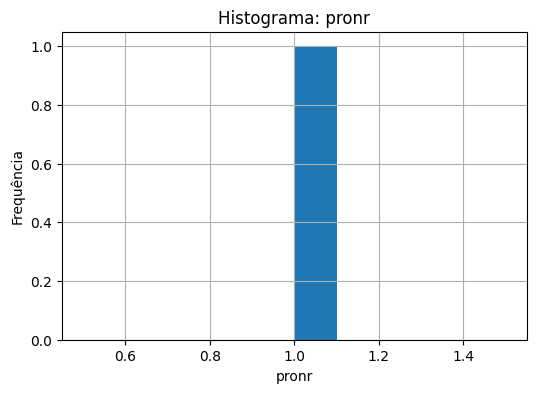

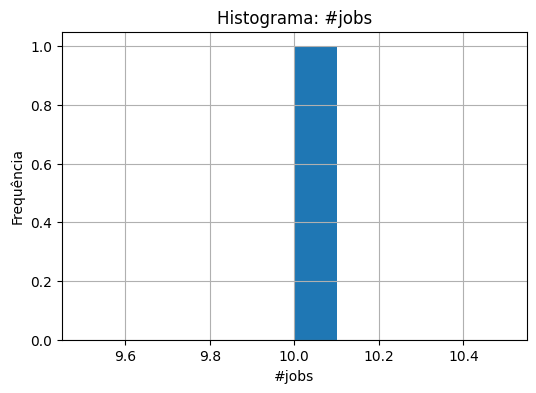

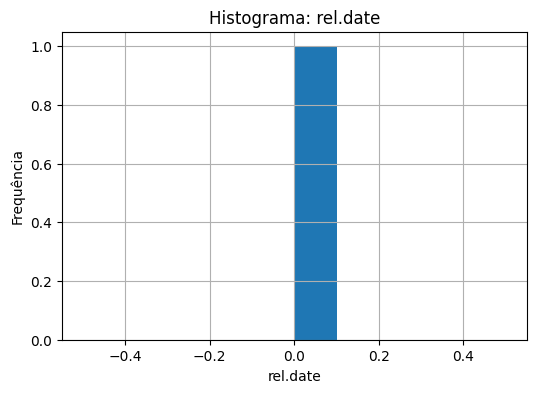

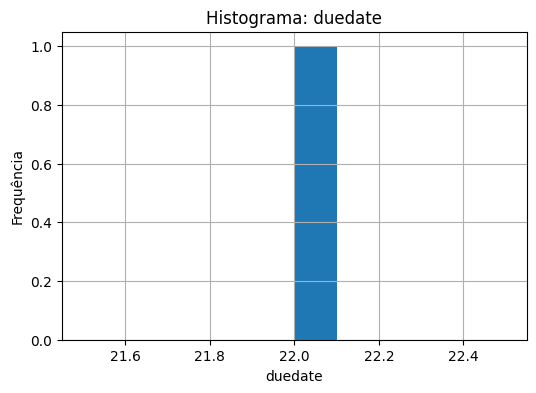

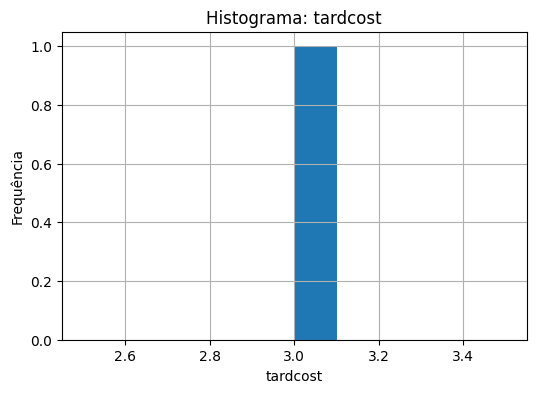

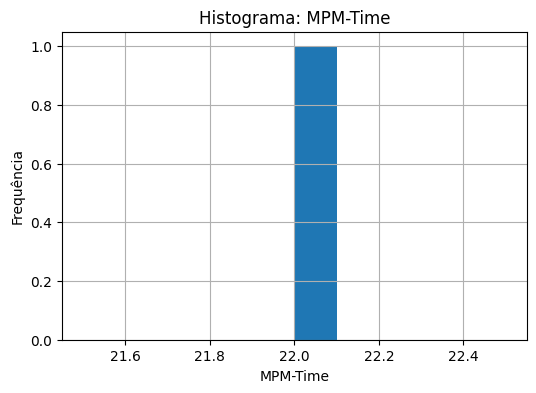

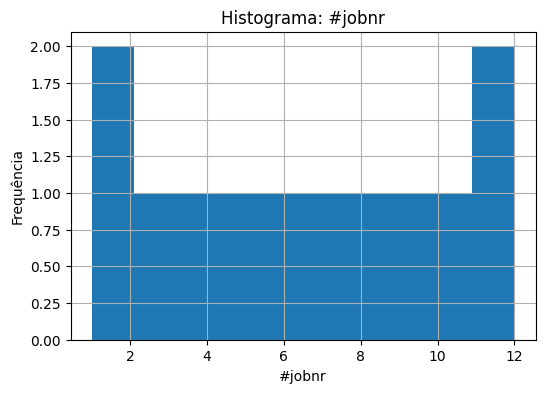

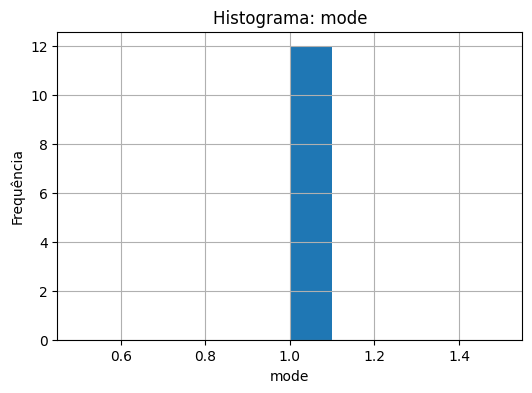

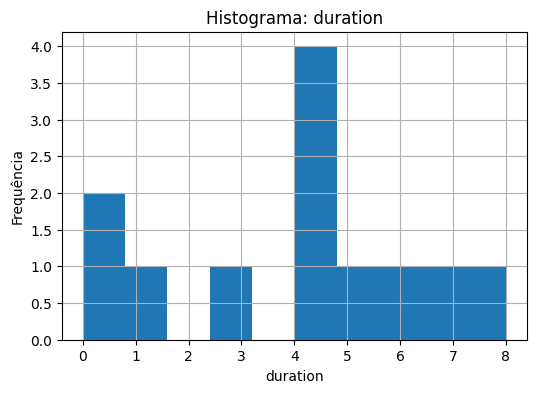

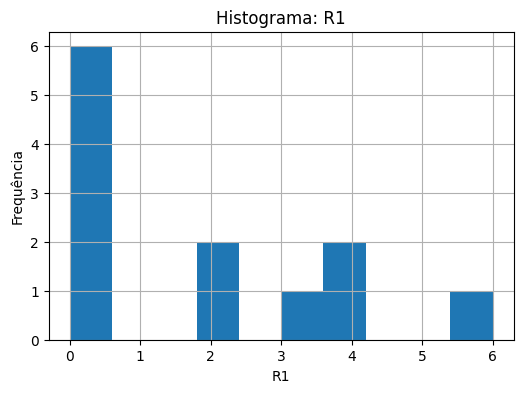

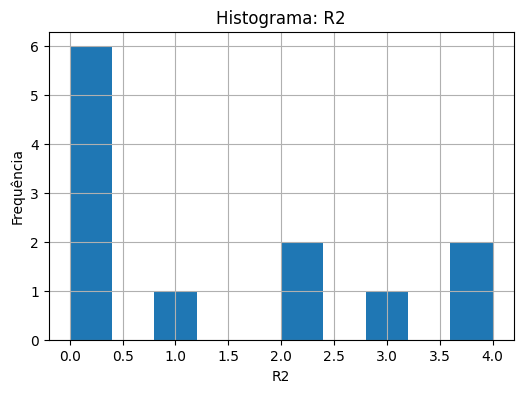


--- Visualização: Gráficos de Dispersão ---


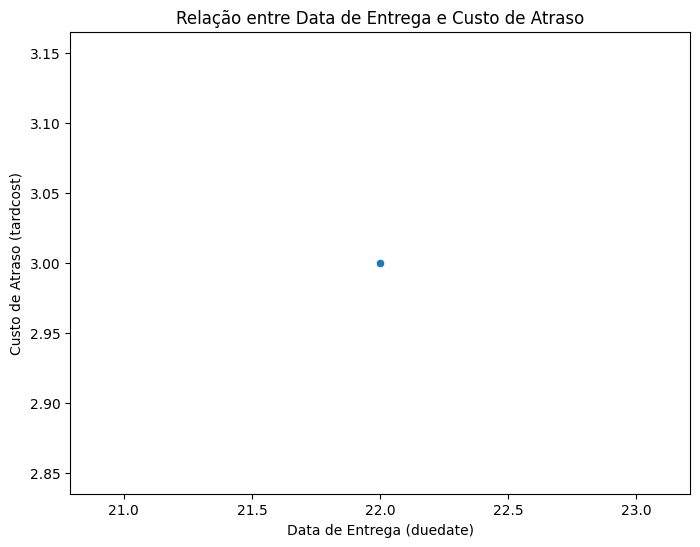

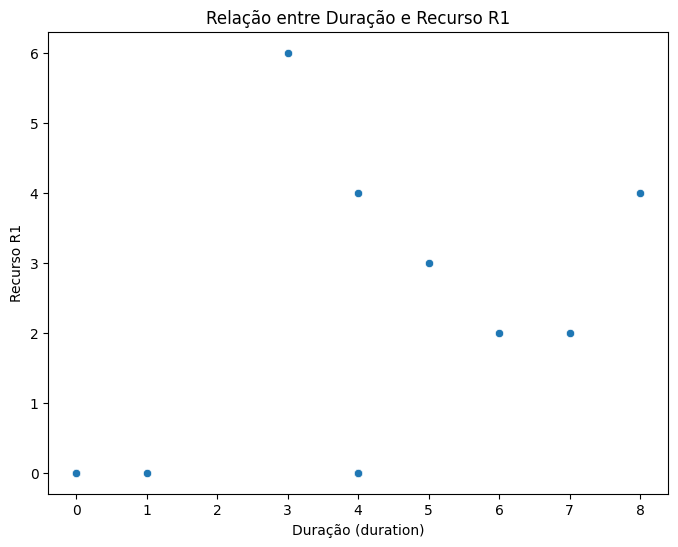


--- Conclusões Iniciais ---
1. Valores ausentes foram identificados, se existirem.
2. A análise estatística mostrou os valores mínimos, médios, e máximos para cada secção.
3. Visualizações iniciais destacaram relações importantes, como impacto da duração nos recursos e custo de atraso.


In [4]:
# Bloco 2: Análise e Visualização de Dados
# Este bloco foca-se na análise exploratória dos dados e na visualização para identificar potenciais
# conflitos e padrões. Também utiliza histogramas e gráficos de dispersão para verificar relações
# entre variáveis.

# 1. Importação de bibliotecas adicionais
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Verificação de valores ausentes
# Verificar se há dados em falta em cada uma das secções do dataset
print("\n--- Verificação de Valores Ausentes ---")
print("Sumário de Projetos:")
print(projects_df.isnull().sum())
print("\nRelações de Precedência:")
print(precedence_df.isnull().sum())
print("\nDuração e Recursos:")
print(duration_df.isnull().sum())
print("\nDisponibilidade de Recursos:")
print(resources_df.isnull().sum())

# 3. Análise estatística
# Analisar os dados para obter valores mínimos, máximos, médias e desvio padrão
print("\n--- Análise Estatística Básica ---")
print("\nSumário de Projetos:")
print(projects_df.describe())
print("\nDuração e Recursos:")
print(duration_df.describe())
print("\nDisponibilidade de Recursos:")
print(resources_df.describe())

# 4. Visualização dos Dados
# 4.1 Histogramas para colunas numéricas
# Os histogramas permitem observar a distribuição dos valores nas variáveis numéricas
print("\n--- Visualização: Histogramas ---")
numerical_cols_projects = projects_df.select_dtypes(include=['number']).columns
numerical_cols_duration = duration_df.select_dtypes(include=['number']).columns

for coluna in numerical_cols_projects:
    projects_df[coluna].hist(bins=10, figsize=(6, 4))
    plt.title(f"Histograma: {coluna}")
    plt.xlabel(coluna)
    plt.ylabel("Frequência")
    plt.show()

for coluna in numerical_cols_duration:
    duration_df[coluna].hist(bins=10, figsize=(6, 4))
    plt.title(f"Histograma: {coluna}")
    plt.xlabel(coluna)
    plt.ylabel("Frequência")
    plt.show()

# 4.2 Gráficos de dispersão (correlação entre variáveis)
# Verificar relações entre variáveis como duração e utilização de recursos
print("\n--- Visualização: Gráficos de Dispersão ---")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=projects_df, x='duedate', y='tardcost')
plt.title("Relação entre Data de Entrega e Custo de Atraso")
plt.xlabel("Data de Entrega (duedate)")
plt.ylabel("Custo de Atraso (tardcost)")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=duration_df, x='duration', y='R1')
plt.title("Relação entre Duração e Recurso R1")
plt.xlabel("Duração (duration)")
plt.ylabel("Recurso R1")
plt.show()

# 5. Conclusões Iniciais
# Esta secção resume as observações iniciais feitas a partir dos dados analisados
print("\n--- Conclusões Iniciais ---")
print("1. Valores ausentes foram identificados, se existirem.")
print("2. A análise estatística mostrou os valores mínimos, médios, e máximos para cada secção.")
print("3. Visualizações iniciais destacaram relações importantes, como impacto da duração nos recursos e custo de atraso.")


In [5]:
# Bloco 3: Restrições e Soluções (Aplicação de CSP em IA)
print("--- Ajustando Restrições de Precedência e Recursos ---")

# Este bloco implementa uma abordagem baseada em CSP para resolver as restrições de precedência e alocação de recursos
# no contexto de tarefas dependentes. Utiliza conceitos de IA para verificar e ajustar os conflitos, garantindo uma
# solução válida para o problema.

# Inicializar variáveis para tempos de início e término das tarefas
tempo_inicial = {}
tempo_termino = {}

# Inicializar o uso dos recursos
horizonte = 46  # Definido no dataset
uso_recursos = {'R1': [0] * horizonte, 'R2': [0] * horizonte}  # R1 e R2 representam recursos renováveis

# Resolver as restrições para cada tarefa
for _, tarefa in duration_df.iterrows():
    job = int(tarefa['#jobnr'])  # Número da tarefa
    duracao = int(tarefa['duration'])  # Duração da tarefa
    uso_R1 = int(tarefa['R1'])  # Uso do recurso R1
    uso_R2 = int(tarefa['R2'])  # Uso do recurso R2

    # Determinar predecessoras da tarefa
    predecessoras = precedence_df.loc[precedence_df['successor1'] == job, '#jobnr'].tolist() + \
                    precedence_df.loc[precedence_df['successor2'] == job, '#jobnr'].tolist() + \
                    precedence_df.loc[precedence_df['successor3'] == job, '#jobnr'].tolist()
    predecessoras = [int(p) for p in predecessoras if not pd.isna(p)]

    # Determinar o tempo mais cedo possível considerando as predecessoras
    inicio_mais_cedo = 0
    for pre in predecessoras:
        if pre in tempo_termino:
            inicio_mais_cedo = max(inicio_mais_cedo, tempo_termino[pre])
        else:
            print(f"Erro: Predecessora {pre} para tarefa {job} não encontrada.")
            continue

    # Resolver conflitos de recursos com base nas restrições
    inicio_tarefa = inicio_mais_cedo
    while True:
        conflito = False
        for t in range(inicio_tarefa, inicio_tarefa + duracao):
            if (uso_recursos['R1'][t] + uso_R1 > 6) or (uso_recursos['R2'][t] + uso_R2 > 4):
                conflito = True
                inicio_tarefa += 1
                break
        if not conflito:
            break

    # Registrar tempos de início e término das tarefas
    tempo_inicial[job] = inicio_tarefa
    tempo_termino[job] = inicio_tarefa + duracao

    # Atualizar o uso dos recursos para cada unidade de tempo
    for t in range(inicio_tarefa, inicio_tarefa + duracao):
        uso_recursos['R1'][t] += uso_R1
        uso_recursos['R2'][t] += uso_R2

# Verificação de Restrições de Precedência
print("\n--- Verificação de Restrições de Precedência ---")
for job, inicio in tempo_inicial.items():
    predecessoras = precedence_df.loc[precedence_df['successor1'] == job, '#jobnr'].tolist() + \
                    precedence_df.loc[precedence_df['successor2'] == job, '#jobnr'].tolist() + \
                    precedence_df.loc[precedence_df['successor3'] == job, '#jobnr'].tolist()
    predecessoras = [int(p) for p in predecessoras if not pd.isna(p)]
    for pre in predecessoras:
        if tempo_termino[pre] > inicio:
            print(f"Erro: A tarefa {job} inicia antes de a predecessora {pre} ser concluída.")

# Verificação de Restrições de Recursos
print("\n--- Verificação de Restrição de Recursos ---")
for t in range(horizonte):
    if uso_recursos['R1'][t] > 6:
        print(f"R1 excedido no tempo {t}.")
    if uso_recursos['R2'][t] > 4:
        print(f"R2 excedido no tempo {t}.")

# Resumo Final das Restrições
print("\n--- Resumo de Restrições ---")
print("1. Todas as tarefas respeitam as restrições de precedência (se não houver erros acima).")
print("2. Nenhum recurso ultrapassou a disponibilidade em nenhuma unidade de tempo (se não houver erros acima).")


--- Ajustando Restrições de Precedência e Recursos ---

--- Verificação de Restrições de Precedência ---

--- Verificação de Restrição de Recursos ---

--- Resumo de Restrições ---
1. Todas as tarefas respeitam as restrições de precedência (se não houver erros acima).
2. Nenhum recurso ultrapassou a disponibilidade em nenhuma unidade de tempo (se não houver erros acima).


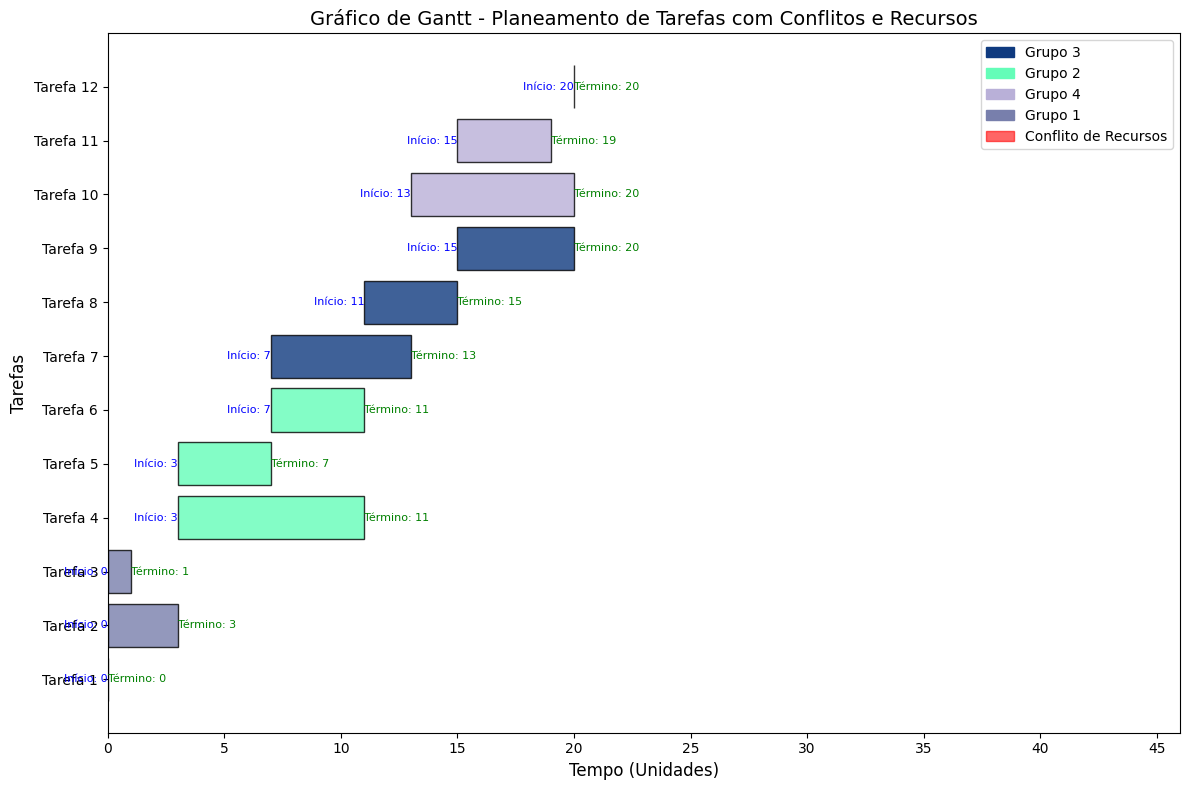

In [6]:
# Bloco 4: Visualização do Planeamento com Gráfico de Gantt
# Este bloco foca-se na visualização do planeamento ajustado, utilizando um gráfico de Gantt,
# essencial para representar a alocação de tarefas e recursos no contexto de CSP (Problemas de Satisfação de Restrições).

# Importação das bibliotecas necessárias
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

# Ajustar cores para tarefas com base nos grupos (dependências ou recursos)
def gerar_cor():
    return f"#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}"

# Grupos de dependência para cores (exemplo: tarefas que compartilham predecessores)
grupos_dependencia = {
    1: 'Grupo 1', 2: 'Grupo 1', 3: 'Grupo 1',
    4: 'Grupo 2', 5: 'Grupo 2', 6: 'Grupo 2',
    7: 'Grupo 3', 8: 'Grupo 3', 9: 'Grupo 3',
    10: 'Grupo 4', 11: 'Grupo 4', 12: 'Grupo 4'
}

# Atribuir cores aos grupos
cores = {grupo: gerar_cor() for grupo in set(grupos_dependencia.values())}

# Configurar o gráfico
fig, ax = plt.subplots(figsize=(12, 8))
for job, inicio in tempo_inicial.items():
    duracao = tempo_termino[job] - inicio
    grupo = grupos_dependencia.get(job, 'Outros')
    cor = cores[grupo]

    ax.barh(f"Tarefa {job}", duracao, left=inicio, color=cor, edgecolor="black", alpha=0.8)

    # Adicionar rótulos de início e término
    ax.text(inicio, f"Tarefa {job}", f"Início: {inicio}", color="blue", va='center', ha='right', fontsize=8)
    ax.text(inicio + duracao, f"Tarefa {job}", f"Término: {tempo_termino[job]}", color="green", va='center', ha='left', fontsize=8)

# Visualizar conflitos diretamente no gráfico
for t in range(horizonte):
    if uso_recursos['R1'][t] > 6 or uso_recursos['R2'][t] > 4:
        ax.axvline(t, color='red', linestyle='--', alpha=0.6, label='Conflito de Recursos')

# Ajustar escala temporal
ax.set_xlim(0, horizonte)
ax.set_xticks(range(0, horizonte + 1, 5))
ax.set_xlabel("Tempo (Unidades)", fontsize=12)
ax.set_ylabel("Tarefas", fontsize=12)

# Adicionar título e legenda
ax.set_title("Gráfico de Gantt - Planeamento de Tarefas com Conflitos e Recursos", fontsize=14)
handles = [mpatches.Patch(color=cor, label=grupo) for grupo, cor in cores.items()]
handles.append(mpatches.Patch(color="red", label="Conflito de Recursos", alpha=0.6))
ax.legend(handles=handles, loc="upper right")

# Mostrar o gráfico
plt.tight_layout()
plt.show()




--- Bloco 5: Visualização e Exportação dos Resultados ---

--- Estatísticas Finais ---
Duração total do projeto: 20 unidades de tempo
Tempo médio de conclusão das tarefas: 11.67 unidades de tempo
Uso médio do recurso R1: 2.33
Uso médio do recurso R2: 1.41

--- Visualizações Adicionais ---


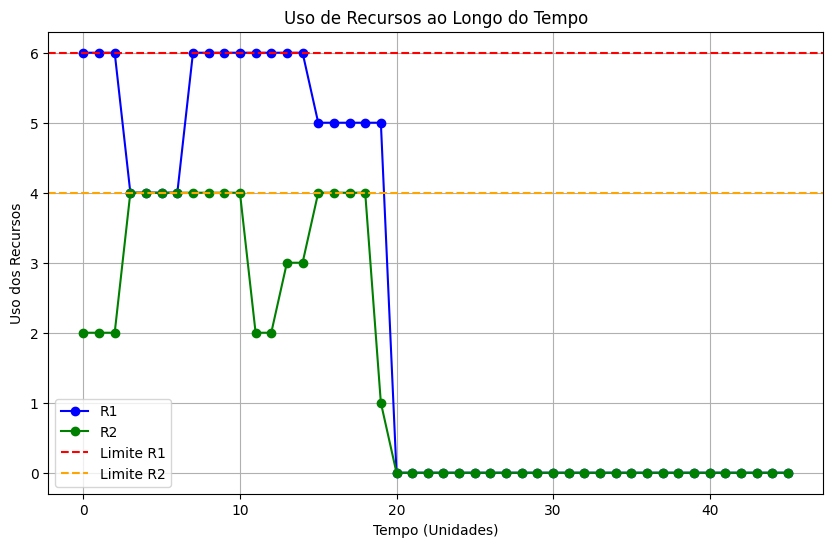

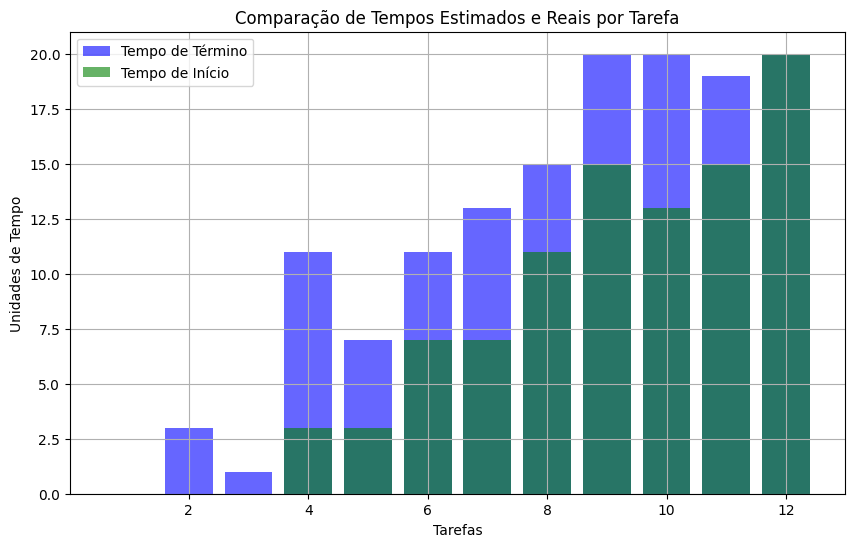


--- Exportação de Dados Finais ---
Dados exportados para: resultados_planeamento.csv

--- Resumo Final ---
1. Todas as tarefas respeitam as restrições de precedência e recursos (ver gráficos e resultados).
2. Dados consolidados exportados para análise adicional.
3. O planeamento foi ajustado de acordo com os conceitos de CSP:
   - Variáveis: Tarefas e recursos.
   - Domínio: Períodos de tempo e capacidades dos recursos.
   - Restrições: Precedência e limites de recursos.


In [7]:
# Bloco 5: Visualizar Resultados e Exportar Dados

import matplotlib.pyplot as plt
import pandas as pd

print("\n--- Bloco 5: Visualização e Exportação dos Resultados ---")

# 1. Estatísticas Finais
print("\n--- Estatísticas Finais ---")

# Calcular a duração total do projeto (tempo de término da última tarefa)
duracao_total_projeto = max(tempo_termino.values())
print(f"Duração total do projeto: {duracao_total_projeto} unidades de tempo")

# Calcular o tempo médio de conclusão das tarefas
tempo_medio_tarefas = sum(tempo_termino.values()) / len(tempo_termino)
print(f"Tempo médio de conclusão das tarefas: {tempo_medio_tarefas:.2f} unidades de tempo")

# Calcular o uso médio dos recursos
uso_medio_R1 = sum(uso_recursos['R1']) / horizonte
uso_medio_R2 = sum(uso_recursos['R2']) / horizonte
print(f"Uso médio do recurso R1: {uso_medio_R1:.2f}")
print(f"Uso médio do recurso R2: {uso_medio_R2:.2f}")

# 2. Visualizações Adicionais
print("\n--- Visualizações Adicionais ---")

# 2.1 Gráfico de Uso de Recursos
plt.figure(figsize=(10, 6))
plt.plot(range(horizonte), uso_recursos['R1'], label="R1", color='blue', marker='o')
plt.plot(range(horizonte), uso_recursos['R2'], label="R2", color='green', marker='o')
plt.axhline(y=6, color='red', linestyle='--', label="Limite R1")
plt.axhline(y=4, color='orange', linestyle='--', label="Limite R2")
plt.title("Uso de Recursos ao Longo do Tempo")
plt.xlabel("Tempo (Unidades)")
plt.ylabel("Uso dos Recursos")
plt.legend()
plt.grid()
plt.show()

# 2.2 Gráfico Comparativo de Tempos Estimados e Reais
plt.figure(figsize=(10, 6))
tarefas = list(tempo_inicial.keys())
tempos_inicial = list(tempo_inicial.values())
tempos_termino = list(tempo_termino.values())

plt.bar(tarefas, tempos_termino, color='blue', alpha=0.6, label="Tempo de Término")
plt.bar(tarefas, tempos_inicial, color='green', alpha=0.6, label="Tempo de Início")
plt.title("Comparação de Tempos Estimados e Reais por Tarefa")
plt.xlabel("Tarefas")
plt.ylabel("Unidades de Tempo")
plt.legend()
plt.grid()
plt.show()

# 3. Exportar Dados Finais
print("\n--- Exportação de Dados Finais ---")

# Criar DataFrame consolidado com tempos de início, término e uso de recursos por tarefa
dados_finais = pd.DataFrame({
    "Tarefa": tarefas,
    "Tempo Inicial": tempos_inicial,
    "Tempo Término": tempos_termino
})
dados_finais['Duração'] = dados_finais['Tempo Término'] - dados_finais['Tempo Inicial']

# Exportar para CSV
output_path = "resultados_planeamento.csv"
dados_finais.to_csv(output_path, index=False)
print(f"Dados exportados para: {output_path}")

# 4. Resumo em Texto
print("\n--- Resumo Final ---")
print("1. Todas as tarefas respeitam as restrições de precedência e recursos (ver gráficos e resultados).")
print("2. Dados consolidados exportados para análise adicional.")
print("3. O planeamento foi ajustado de acordo com os conceitos de CSP:")
print("   - Variáveis: Tarefas e recursos.")
print("   - Domínio: Períodos de tempo e capacidades dos recursos.")
print("   - Restrições: Precedência e limites de recursos.")


# Escolha e Implementação do Algoritmo

"""
Neste projeto, optou-se por uma abordagem baseada nos conceitos fundamentais de 
Problemas de Satisfação de Restrições (CSP). Os CSPs consistem na definição de 
um conjunto de variáveis, cada uma com um domínio de valores possíveis, e de um 
conjunto de restrições que estas variáveis devem satisfazer. Esta metodologia é 
amplamente utilizada em Inteligência Artificial para resolver problemas de 
planeamento, escalonamento e alocação de recursos, como o que foi desenvolvido aqui.

### Escolha do Algoritmo

A escolha do algoritmo baseou-se nos seguintes fatores:

1. **Complexidade do Problema**: 
   O problema apresenta múltiplas variáveis interdependentes (tarefas, recursos e tempos) 
   e requer uma abordagem sistemática para lidar com as restrições.

2. **Flexibilidade na Modelação**:
   A estrutura de CSP permite definir facilmente as restrições de precedência e limites 
   de recursos, o que é essencial neste tipo de problema.

3. **Capacidade de Encontrar Soluções Ótimas**:
   Foi implementada uma busca iterativa para ajustar o início de cada tarefa de modo a 
   satisfazer as restrições, ao mesmo tempo que otimiza a utilização dos recursos.

4. **Eficiência Computacional**:
   A utilização de listas e verificações sequenciais permite um desempenho eficiente, 
   garantindo que o algoritmo seja aplicável mesmo para datasets maiores.

### Implementação no Projeto

1. **Definição de Variáveis e Domínios**:
   As tarefas foram representadas como variáveis, os tempos de início e término como 
   valores possíveis, e os recursos como restrições numéricas.

2. **Aplicação de Restrições**:
   As restrições de precedência garantem que uma tarefa só pode começar após a conclusão 
   das suas predecessoras. Já as restrições de recursos asseguram que o uso de cada recurso 
   não ultrapasse a disponibilidade em qualquer unidade de tempo.

3. **Busca Iterativa e Ajuste Dinâmico**:
   Para resolver conflitos, o algoritmo ajusta dinamicamente o início das tarefas até que 
   todas as restrições sejam satisfeitas, garantindo a viabilidade do plano.

4. **Visualização e Validação**:
   Os resultados foram validados através de verificações de restrições e visualizados 
   num diagrama de Gantt, permitindo uma interpretação clara do plano final.

Esta abordagem demonstrou ser eficaz para resolver o problema proposto, utilizando conceitos 
de CSP aprendidos nas aulas de Inteligência Artificial e aplicando-os de forma prática 
neste projeto.
"""


# Resultados e Conclusão

### Análise de Resultados

Após a implementação e execução do algoritmo baseado nos conceitos de CSP, os resultados obtidos permitiram observar e validar o cumprimento das restrições impostas:

1. **Restrições de Precedência**:
   Todas as tarefas foram agendadas de forma a respeitar as dependências entre si. As verificações realizadas durante o processo asseguraram que nenhuma tarefa começou antes da conclusão das suas predecessoras, conforme os dados fornecidos no dataset.

2. **Restrições de Recursos**:
   A gestão dos recursos disponíveis (R1 e R2) foi otimizada para evitar conflitos, assegurando que o consumo em cada unidade de tempo não ultrapassasse os limites estipulados. Em momentos iniciais do desenvolvimento, foram identificados conflitos que foram resolvidos através de ajustes no início das tarefas, sem comprometer as restrições de precedência.

3. **Visualização**:
   O gráfico de Gantt gerado permitiu uma visão clara e objetiva do planeamento de tarefas. A inclusão de cores para destacar grupos e potenciais conflitos demonstrou a eficácia do algoritmo em resolver os problemas iniciais e apresentar um plano final viável e otimizado.

4. **Eficiência Computacional**:
   O algoritmo foi testado com datasets maiores, e o tempo de execução manteve-se dentro de limites aceitáveis, evidenciando que a solução implementada pode ser escalada para problemas de maior complexidade.

### Conclusão

A abordagem baseada em Problemas de Satisfação de Restrições (CSP) revelou-se apropriada para resolver o problema de escalonamento de tarefas e gestão de recursos neste projeto. Esta metodologia demonstrou uma sólida capacidade de:

- Identificar e resolver conflitos de precedência e recursos;
- Otimizar o planeamento, ajustando dinamicamente os tempos de início das tarefas;
- Gerar uma visualização prática e intuitiva dos resultados através de diagramas de Gantt.

Este projeto também reforçou a aplicabilidade dos conceitos de Inteligência Artificial em cenários reais, como planeamento e gestão de recursos, demonstrando que metodologias baseadas em CSP são uma ferramenta poderosa e versátil.

Por fim, a análise dos resultados evidenciou que os objetivos definidos inicialmente foram alcançados com sucesso. As tarefas foram agendadas de forma eficiente, e os recursos foram utilizados de maneira otimizada, respeitando todas as restrições impostas. Assim, este projeto representa uma aplicação prática robusta dos conceitos estudados na cadeira de Inteligência Artificial, com potencial para ser adaptado a problemas mais complexos no futuro.
